In [213]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner.corner
from emcee.autocorr import integrated_time
from impulse.base import PTTestSampler

# test model things:
from test_model import make_sin_data, LnLikelihood, LnPrior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
x, data, omega_real, a_real, phi_real = make_multiple_sin_data(1000, 2)

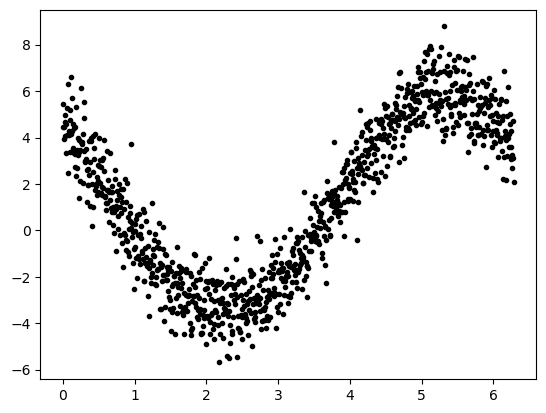

In [215]:
plt.plot(x, data, 'k.')

In [231]:
class LogLikelihood:
    def __init__(self, x, data, sigma=1):
        self.x = x
        self.sigma = sigma
        self.data = data

    def __call__(self, params):
        if len(params) % 3 != 0:
            raise ValueError("Number of parameters must be a factor of 3")
        omega = params[0::3]
        a = params[1::3]
        phi = params[2::3]
        
        func = np.array([a * np.sin(omega * self.x + phi) for omega, a, phi in zip(omega, a, phi)])
        result = np.sum(-0.5 * (np.sum(func, axis=0) - self.data)**2)
        if np.isfinite(result):
            return result
        else:
            return -np.inf

class LogPrior:
    def __init__(self, omega_range=(0, 3), a_range=(0, 5), phi_range=(0, np.pi)):
        self.omega_min = omega_range[0]
        self.omega_max = omega_range[1]
        self.a_min = a_range[0]
        self.a_max = a_range[1]
        self.phi_min = phi_range[0]
        self.phi_max = phi_range[1]

    def __call__(self, params):
        if len(params) % 3 != 0:
            raise ValueError("Number of parameters must be a factor of 3")
        omega = params[0::3]
        a = params[1::3]
        phi = params[2::3]
        if np.any(omega < self.omega_min) or np.any(omega > self.omega_max):
            return -np.inf
        if np.any(a < self.a_min) or np.any(a > self.a_max):
            return -np.inf
        if np.any(phi < self.phi_min) or np.any(phi > self.phi_max):
            return -np.inf
        else:
            return 0

In [232]:
class ProductSpace:
    def __init__(self,
                 model_names: list,
                 loglikelihoods: list,
                 logpriors: list,
                 param_names: list[list[str]]):
        self.model_names = model_names
        self.loglikelihoods = loglikelihoods
        self.logpriors = logpriors
        self.num_models = len(self.model_names)
        self.nmodels = np.arange(self.num_models)

        # get unique parameters for output
        all_params = []
        for param_list in param_names:
            for i in range(len(param_list)):
                all_params.append(param_list[i])
        all_params.append('nmodel')

        self.unique_params, unique_param_idxs = np.unique(all_params, return_index=True)
        self.unique_params = self.unique_params[np.argsort(unique_param_idxs)]
        self.ndim = len(self.unique_params)

        # get correspondence between unique parameters and model parameters
        self.model_params = []  # should be as long as number of models
        for param_list in param_names:
            temp_param_idxs = []
            for i in range(len(param_list)):
                temp_param_idxs.append(list(self.unique_params).index(param_list[i]))
            self.model_params.append(np.array(temp_param_idxs))

    def loglikelihood(self, x):

        # find model index variable
        idx = list(self.unique_params).index('nmodel')
        nmodel = int(np.rint(x[idx]))

        # only active parameters enter likelihood
        active_lnlike = self.loglikelihoods[nmodel]
        return active_lnlike(x[self.model_params[nmodel]])

    def logprior(self, x):
        
        # find model index variable
        idx = list(self.unique_params).index('nmodel')
        nmodel = int(np.rint(x[idx]))

        if nmodel not in self.nmodels:
            return -np.inf
        
        active_lnprior = self.logpriors[nmodel]
        return active_lnprior(x[self.model_params[nmodel]])


In [233]:
param_names = [['omega1', 'a1', 'phi1'], ['omega1', 'a1', 'phi1', 'omega2', 'a2', 'phi2']]

In [234]:
pspace = ProductSpace(['model1', 'model2'], [LogLikelihood(x, data), LogLikelihood(x, data)], [LogPrior(), LogPrior()], param_names)

In [235]:
pspace.model_params

[array([0, 1, 2]), array([0, 1, 2, 3, 4, 5])]